In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az

sns.set()


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dick = pd.read_pickle('country_data.pkl')
world_df = pd.read_pickle('global_data.pkl')

swe = dick['Sweden']
swe


confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-01-24          0       NaN    NaN         0          NaN       NaN   
2020-01-25          0       NaN    0.0         0          NaN       0.0   
2020-01-26          0       NaN    0.0         0          NaN       0.0   
2020-01-27          0       NaN    0.0         0          NaN       0.0   
2020-01-28          0       NaN    0.0         0          NaN       0.0   
...               ...       ...    ...       ...          ...       ...   
2020-08-27      83958  1.001599  134.0      5820     1.000688       4.0   
2020-08-28      83958  1.000000    0.0      5821     1.000172       1.0   
2020-08-29      83958  1.000000    0.0      5821     1.000000       0.0   
2020-08-30      83958  1.000000    0.0      5821     1.000000       0.0   
2020-08-31      84379  1.005014  421.0      5808     0.997767     -13.0   

            pct_dead  conf_over_dead  dead_conf_ratio  
2020-01-24       NaN             NaN              NaN  
2020-01-25       NaN             NaN              NaN  
2020-01-26       NaN             NaN              NaN  
2020-01-27       NaN             NaN              NaN  
2020-01-28       NaN             NaN              NaN  
...              ...             ...              ...  
2020-08-27  6.932037       14.425773         0.999091  
2020-08-28  6.933229       14.423295         1.000172  
2020-08-29  6.933229       14.423295         1.000000  
2020-08-30  6.933229       14.423295         1.000000  
2020-08-31  6.883229       14.528065         0.992788  

[221 rows x 9 columns]

In [3]:
# fix erroneous data
esp = dick['Spain']
print (esp.loc['2020-04-24'])
esp.at['2020-04-24','inc'] = 1 # poisson cant deal with negative numbers
dick['Spain'] = esp

uk = dick['United Kingdom']
uk.at['2020-05-20','inc'] = 1
dick['United Kingdom'] = uk


### THERE's something in swe data between 0821 - 0831 that causes inference to fail ###

### ALSO: testing to do inf on data after April-May-Peak to hopefully get less variance
swe = dick['Sweden']

swe = swe[120:-10].copy() # drop neg dead_inc day

swe.dropna(inplace=True)
dick['Sweden'] = swe

confirmed          202990.000000
factor                  0.952897
inc                -10034.000000
deceased            22524.000000
dead_factor             1.016564
dead_inc              367.000000
pct_dead               11.096113
conf_over_dead          9.012165
dead_conf_ratio         1.066813
Name: 2020-04-24 00:00:00, dtype: float64


In [4]:
US = pd.read_pickle('us_state_dict.pkl')
ny = US['New York']
ny = ny[['confirmed','deceased','inc','factor','dead_inc','dead_factor','pct_dead']]
dick['New York'] = ny
ny

confirmed  deceased       inc    factor  dead_inc  dead_factor  \
2020-03-14      525.0       2.0     104.0  1.247031       2.0          NaN   
2020-03-15      732.0       3.0     207.0  1.394286       1.0     1.500000   
2020-03-16      967.0      10.0     235.0  1.321038       7.0     3.333333   
2020-03-17     1706.0      13.0     739.0  1.764219       3.0     1.300000   
2020-03-18     2495.0      16.0     789.0  1.462485       3.0     1.230769   
...               ...       ...       ...       ...       ...          ...   
2020-08-26   431340.0   32921.0     566.0  1.001314       3.0     1.000091   
2020-04-14   203020.0   10842.0 -228320.0  0.470673  -22079.0     0.329334   
2020-06-08   378799.0   30417.0  175779.0  1.865821   19575.0     2.805479   
2020-07-31   415014.0   32689.0   36215.0  1.095605    2272.0     1.074695   
2020-04-15   214454.0   11617.0 -200560.0  0.516739  -21072.0     0.355379   

            pct_dead  
2020-03-14  0.380952  
2020-03-15  0.409836  
2020-03-16  1.034126  
2020-03-17  0.762016  
2020-03-18  0.641283  
...              ...  
2020-08-26  7.632262  
2020-04-14  5.340361  
2020-06-08  8.029852  
2020-07-31  7.876602  
2020-04-15  5.417013  

[171 rows x 7 columns]

++++++++ Sweden ++++++++++

            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-07-13      73049  1.002333  170.0      5672     1.001412       8.0   
2020-07-14      73364  1.004312  315.0      5678     1.001058       6.0   
2020-07-15      73663  1.004076  299.0      5686     1.001409       8.0   
2020-07-16      73936  1.003706  273.0      5694     1.001407       8.0   
2020-07-17      74235  1.004044  299.0      5705     1.001932      11.0   
2020-07-18      74435  1.002694  200.0      5715     1.001753      10.0   
2020-07-19      74545  1.001478  110.0      5722     1.001225       7.0   
2020-07-20      74676  1.001757  131.0      5729     1.001223       7.0   
2020-07-21      74902  1.003026  226.0      5736     1.001222       7.0   
2020-07-22      75199  1.003965  297.0      5742     1.001046       6.0   
2020-07-23      75419  1.002926  220.0      5746     1.000697       4.0   
2020-07-24      75681  1.003474  262.0      5747     1.000174       1.0 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F, M, M_beta, M_alpha, F_sigma, F_mu]


Sampling 4 chains for 500 tune and 599 draw iterations (2_000 + 2_396 draws total) took 51 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
F_mu       2.09    0.80    1.10     3.62       0.03     0.02    532.95   
F_sigma    0.49    0.24    0.11     0.86       0.01     0.01   1078.85   
M_alpha    4.93    2.48    1.01     9.02       0.10     0.07    618.16   
M_beta   763.82  137.83  540.89   999.52       3.61     2.55   1461.19   
M          0.01    0.00    0.00     0.01       0.00     0.00    534.28   
F         11.24   18.18    1.01    32.15       0.83     0.59    477.09   

          ess_sd  ess_bulk  ess_tail  r_hat  
F_mu      512.83    588.69    712.95   1.00  
F_sigma  1078.85   1038.05   1165.65   1.00  
M_alpha   618.16    602.09    968.42   1.01  
M_beta   1461.19   1422.60   1275.46   1.01  
M         534.28    478.22    568.36   1.00  
F         477.09    478.13    568.66   1.00  

       M_alpha_post  M_beta_post    F_mu_post  F_sigma_post       M_post  \
count   2396.000000  2396.000000  2396.000000   2396.000000  2396.000000   
mean  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F, M, M_beta, M_alpha, F_sigma, F_mu]


Sampling 4 chains for 500 tune and 599 draw iterations (2_000 + 2_396 draws total) took 258 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: Fu

           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
F_mu       1.98    0.77    1.10     3.49       0.03     0.02    583.43   
F_sigma    0.50    0.22    0.10     0.84       0.01     0.00   1067.91   
M_alpha    4.11    2.28    1.00     8.34       0.08     0.06    731.79   
M_beta   774.43  142.55  544.69   999.55       3.59     2.57   1577.43   
M          0.00    0.00    0.00     0.01       0.00     0.00    650.26   
F          9.36   16.30    0.65    28.20       0.72     0.51    519.19   

          ess_sd  ess_bulk  ess_tail  r_hat  
F_mu      574.94    614.63    786.38   1.00  
F_sigma  1067.91   1055.13    993.15   1.00  
M_alpha   731.79    643.94    924.80   1.00  
M_beta   1534.71   1456.82    853.91   1.01  
M         650.26    514.54    538.25   1.00  
F         519.19    514.97    538.25   1.01  

       M_alpha_post  M_beta_post    F_mu_post  F_sigma_post       M_post  \
count   2396.000000  2396.000000  2396.000000   2396.000000  2396.000000   
mean  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F, M, M_beta, M_alpha, F_sigma, F_mu]


Sampling 4 chains for 500 tune and 599 draw iterations (2_000 + 2_396 draws total) took 120 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
F_mu       2.16    0.78    1.10     3.59       0.04     0.03    454.22   
F_sigma    0.48    0.23    0.10     0.84       0.01     0.00   1072.37   
M_alpha    5.17    2.47    1.20     9.39       0.10     0.07    619.35   
M_beta   763.59  143.19  537.53   999.11       4.17     2.95   1178.17   
M          0.01    0.00    0.00     0.01       0.00     0.00    557.55   
F         11.39   14.31    1.70    33.15       0.72     0.51    392.25   

          ess_sd  ess_bulk  ess_tail  r_hat  
F_mu      422.79    537.11    644.61    1.0  
F_sigma  1059.32   1132.79   1137.74    1.0  
M_alpha   619.35    629.43    820.51    1.0  
M_beta   1178.17   1072.58    985.09    1.0  
M         557.55    446.98    528.03    1.0  
F         392.25    447.69    517.48    1.0  

       M_alpha_post  M_beta_post    F_mu_post  F_sigma_post       M_post  \
count   2396.000000  2396.000000  2396.000000   2396.000000  2396.000000   
mean  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F, M, M_beta, M_alpha, F_sigma, F_mu]


Sampling 4 chains for 500 tune and 599 draw iterations (2_000 + 2_396 draws total) took 308 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
F_mu       2.96    0.82    1.49     4.47       0.03     0.02    694.11   
F_sigma    0.50    0.23    0.15     0.90       0.01     0.01    905.82   
M_alpha    5.77    2.41    1.77     9.83       0.09     0.06    707.85   
M_beta   748.60  146.77  519.95   989.88       4.04     2.87   1316.67   
M          0.01    0.00    0.00     0.02       0.00     0.00    679.23   
F         25.40   26.38    4.30    64.25       1.24     0.88    449.15   

          ess_sd  ess_bulk  ess_tail  r_hat  
F_mu      607.80    714.68    605.52   1.01  
F_sigma   863.48    838.30    835.31   1.00  
M_alpha   707.85    707.74    818.78   1.00  
M_beta   1309.53   1258.82   1069.98   1.00  
M         679.23    580.54    544.34   1.01  
F         449.15    580.55    544.34   1.01  

       M_alpha_post  M_beta_post    F_mu_post  F_sigma_post       M_post  \
count   2396.000000  2396.000000  2396.000000   2396.000000  2396.000000   
mean  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F, M, M_beta, M_alpha, F_sigma, F_mu]


Sampling 4 chains for 500 tune and 599 draw iterations (2_000 + 2_396 draws total) took 248 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
F_mu       3.05    0.83    1.73     4.75       0.03     0.02    609.59   
F_sigma    0.51    0.23    0.12     0.87       0.01     0.00   1217.44   
M_alpha    5.64    2.52    1.67     9.93       0.10     0.07    649.87   
M_beta   750.51  144.84  531.93   998.81       4.28     3.04   1145.76   
M          0.01    0.00    0.00     0.02       0.00     0.00    612.35   
F         28.78   27.78    4.36    77.50       1.22     0.86    518.57   

          ess_sd  ess_bulk  ess_tail  r_hat  
F_mu      579.66    623.83    684.38   1.01  
F_sigma  1179.61   1189.47   1132.89   1.00  
M_alpha   649.87    653.82    988.26   1.01  
M_beta   1134.39   1170.72   1229.87   1.00  
M         612.35    539.30    613.18   1.01  
F         518.57    538.33    617.34   1.01  

       M_alpha_post  M_beta_post    F_mu_post  F_sigma_post       M_post  \
count   2396.000000  2396.000000  2396.000000   2396.000000  2396.000000   
mean  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F, M, M_beta, M_alpha, F_sigma, F_mu]


Sampling 4 chains for 500 tune and 599 draw iterations (2_000 + 2_396 draws total) took 420 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3

           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
F_mu       2.68    0.92    1.10     4.34       0.08     0.06    142.31   
F_sigma    0.49    0.23    0.11     0.85       0.01     0.01    684.94   
M_alpha    5.51    2.53    1.45     9.75       0.19     0.14    175.09   
M_beta   751.76  145.53  516.03   984.29       4.93     3.49    872.04   
M          0.01    0.00    0.00     0.02       0.00     0.00    163.98   
F         21.55   27.37    2.95    67.03       2.23     1.58    151.10   

         ess_sd  ess_bulk  ess_tail  r_hat  
F_mu     135.70    152.48    233.53   1.03  
F_sigma  684.94    626.68    682.24   1.00  
M_alpha  175.09    177.27    494.96   1.03  
M_beta   870.12    805.35    846.10   1.00  
M        163.98    140.73    304.96   1.03  
F        151.10    140.68    304.96   1.03  

       M_alpha_post  M_beta_post    F_mu_post  F_sigma_post       M_post  \
count   2396.000000  2396.000000  2396.000000   2396.000000  2396.000000   
mean       5.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F, M, M_beta, M_alpha, F_sigma, F_mu]


Sampling 4 chains for 500 tune and 599 draw iterations (2_000 + 2_396 draws total) took 283 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: Fu

           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
F_mu       2.07    0.72    1.10     3.41       0.04     0.03    274.42   
F_sigma    0.50    0.23    0.14     0.88       0.01     0.01    757.81   
M_alpha    4.82    2.44    1.00     8.96       0.12     0.09    399.48   
M_beta   762.95  143.51  539.16   999.52       4.12     2.92   1211.38   
M          0.01    0.00    0.00     0.01       0.00     0.00    307.41   
F          9.41   10.71    1.30    25.47       0.63     0.45    289.71   

          ess_sd  ess_bulk  ess_tail  r_hat  
F_mu      274.42    324.86    635.92   1.03  
F_sigma   748.20    716.96   1030.09   1.01  
M_alpha   399.48    369.69    922.28   1.01  
M_beta   1211.38   1116.58    979.62   1.00  
M         307.41    260.91    572.24   1.02  
F         289.71    260.92    572.24   1.02  

       M_alpha_post  M_beta_post    F_mu_post  F_sigma_post       M_post  \
count   2396.000000  2396.000000  2396.000000   2396.000000  2396.000000   
mean  

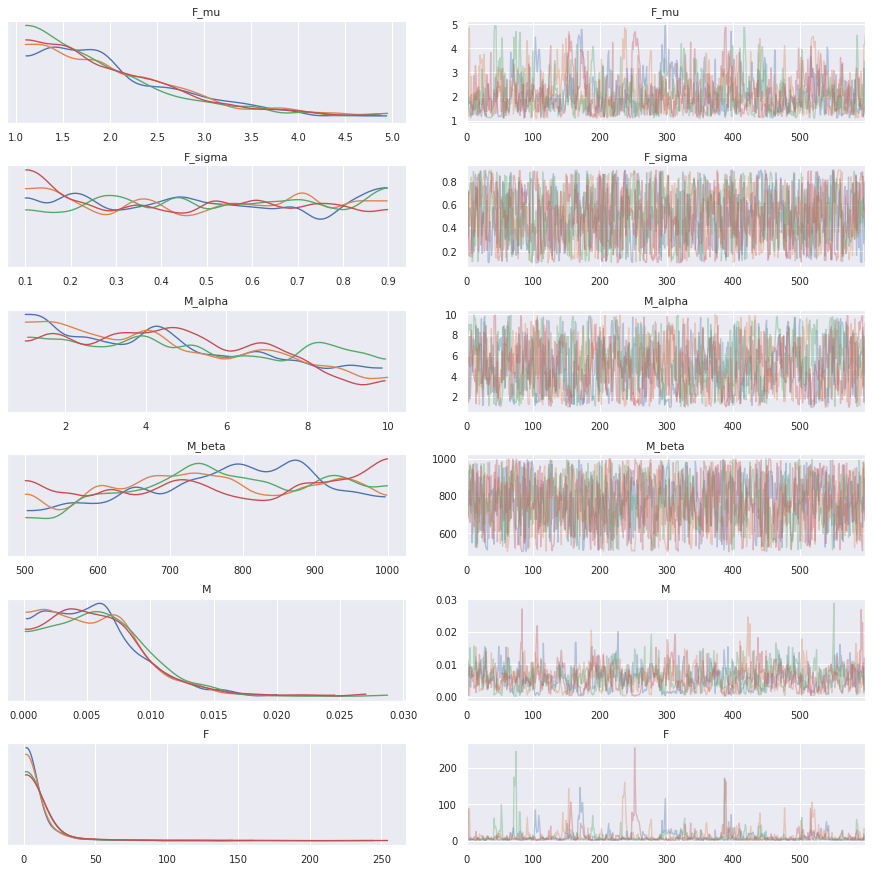

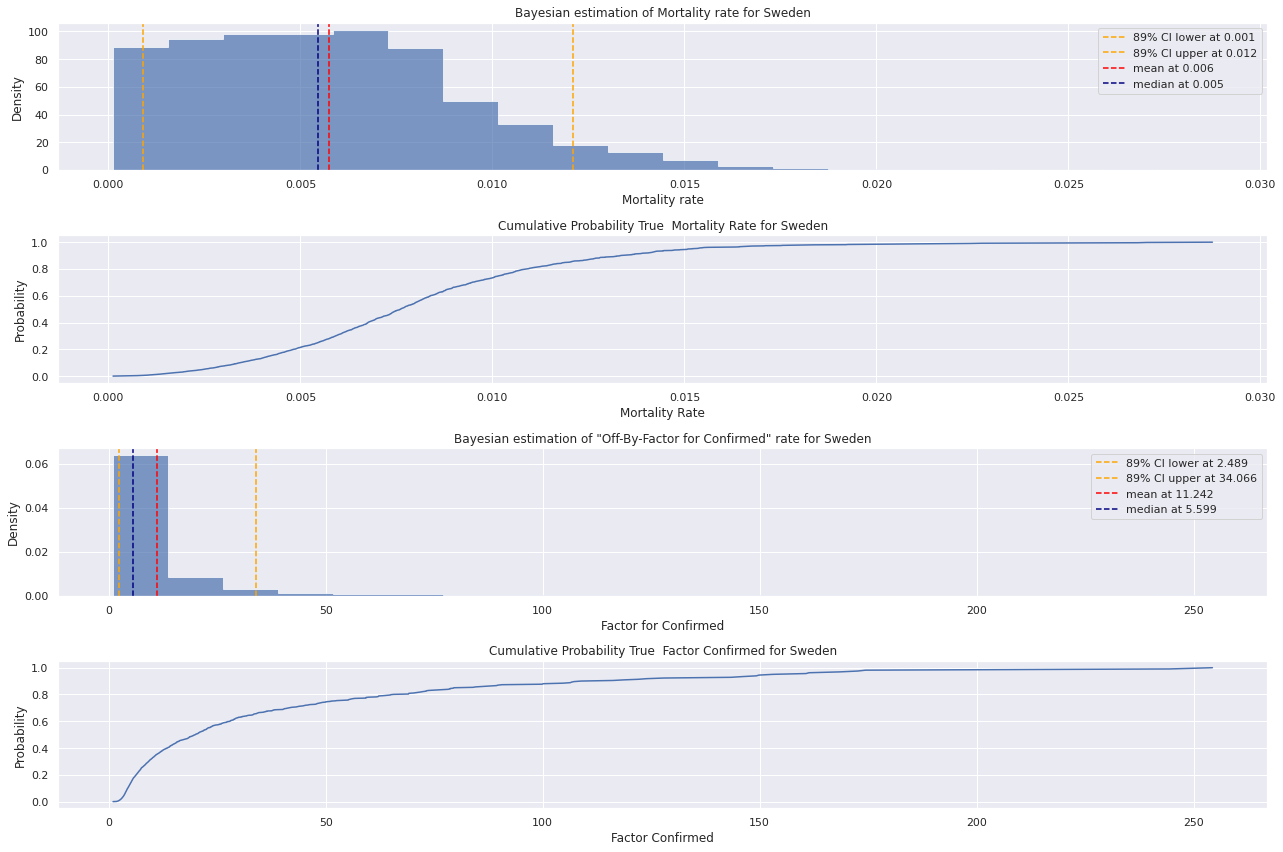

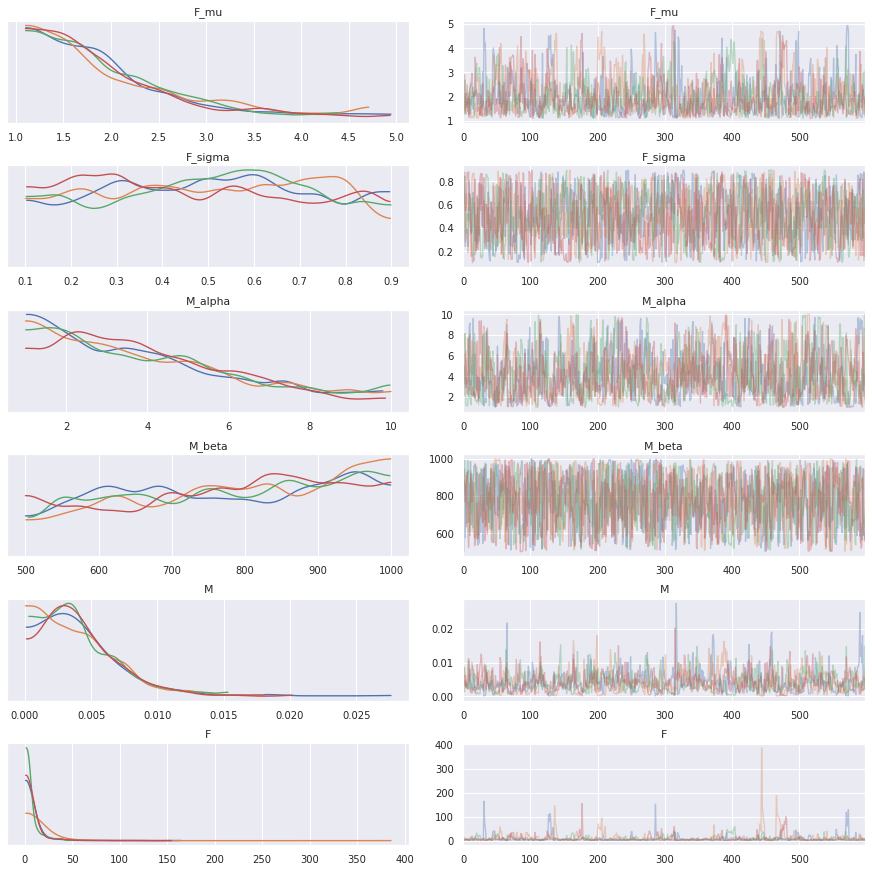

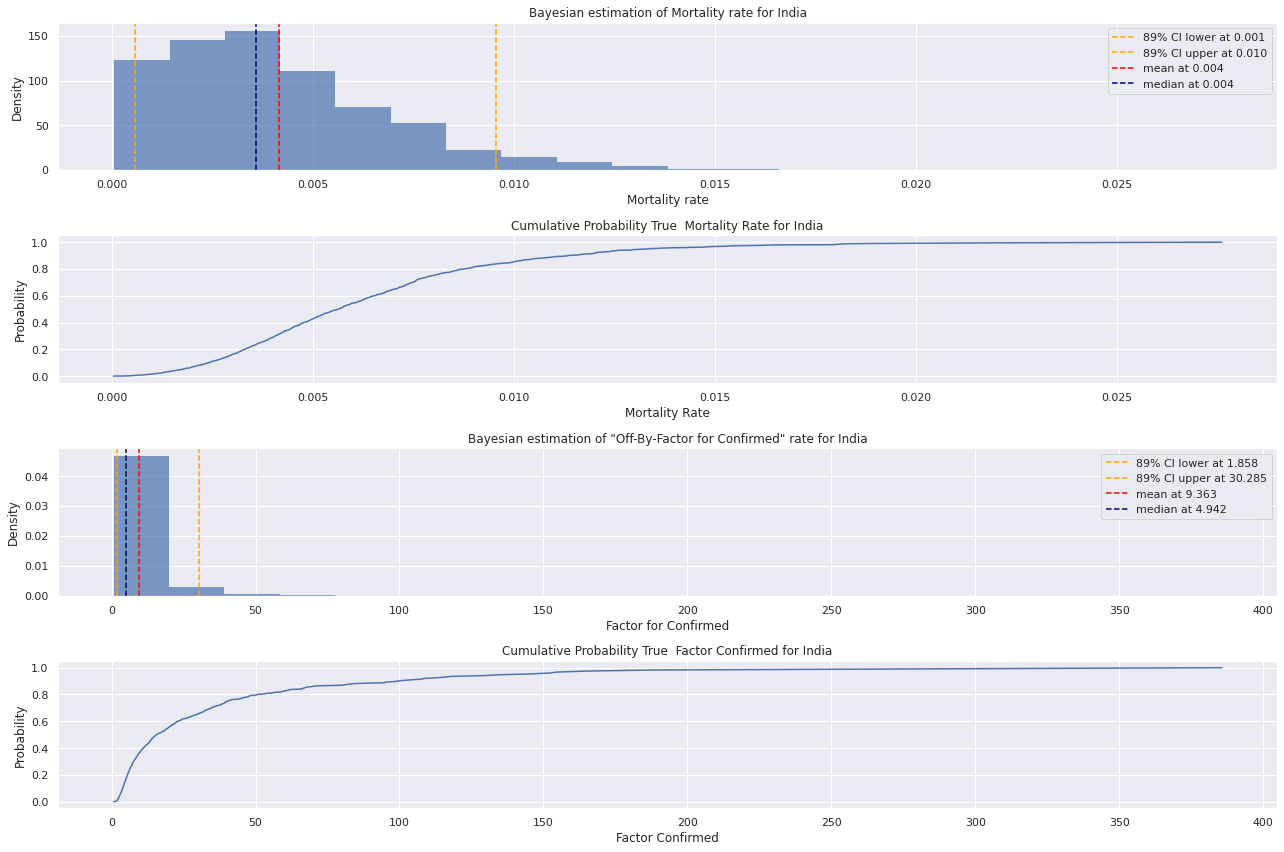

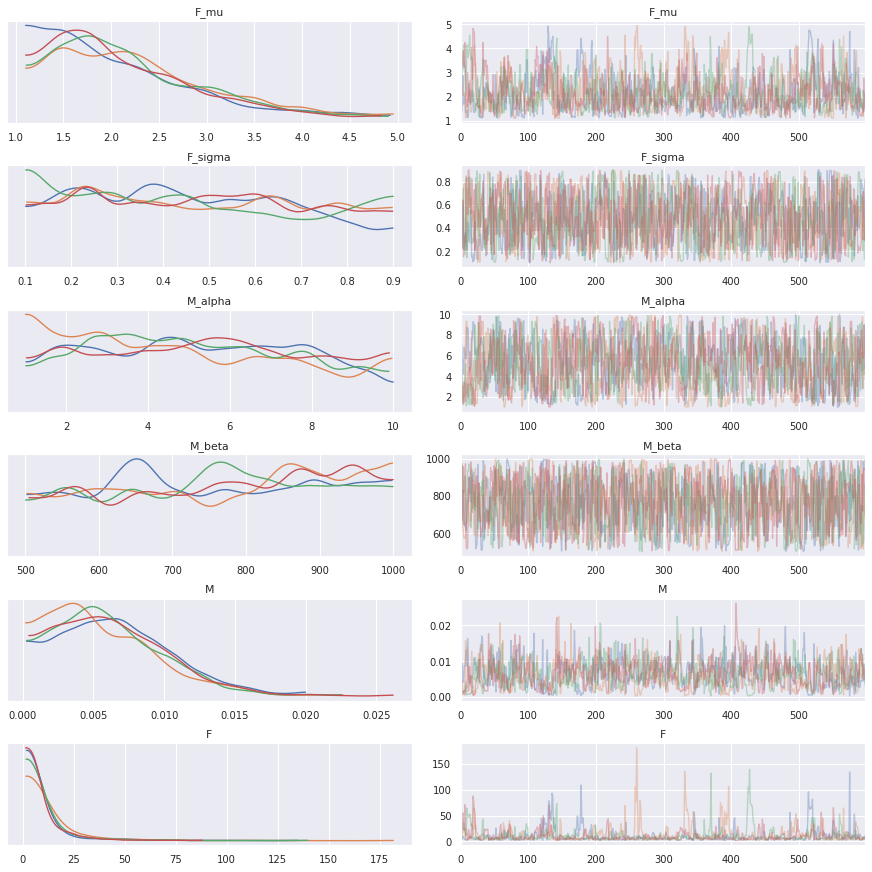

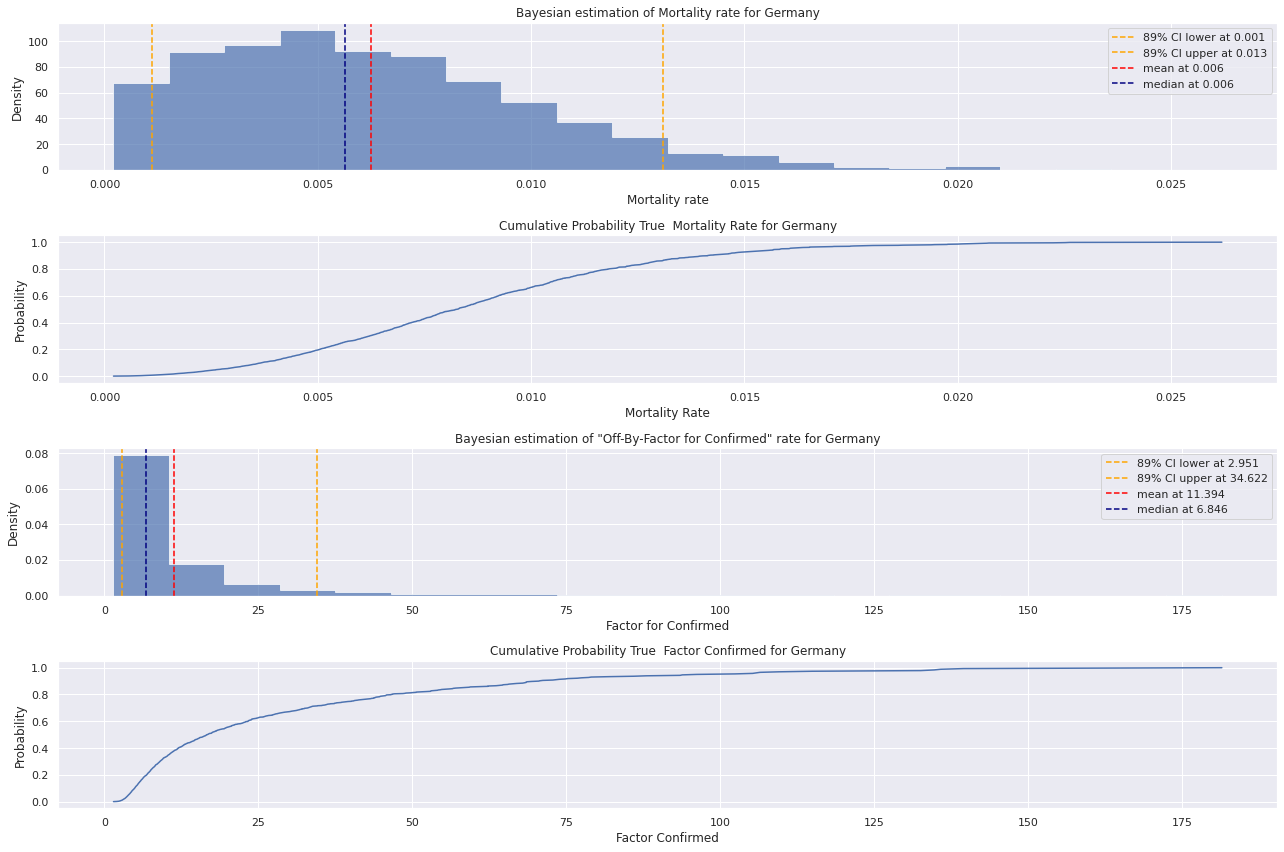

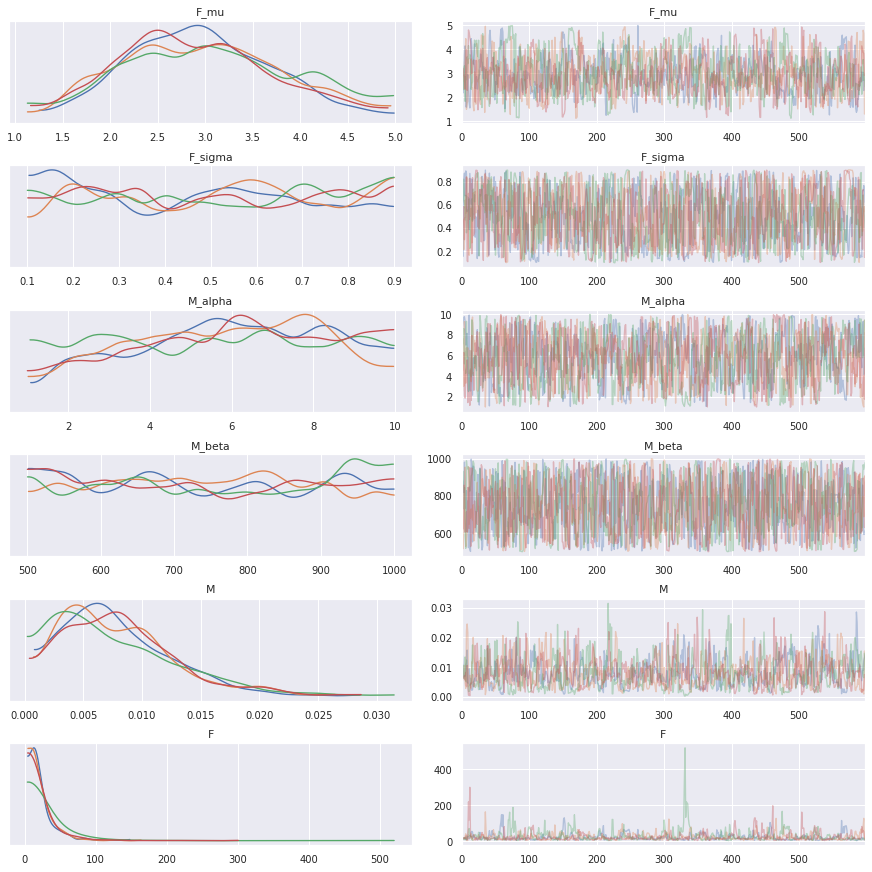

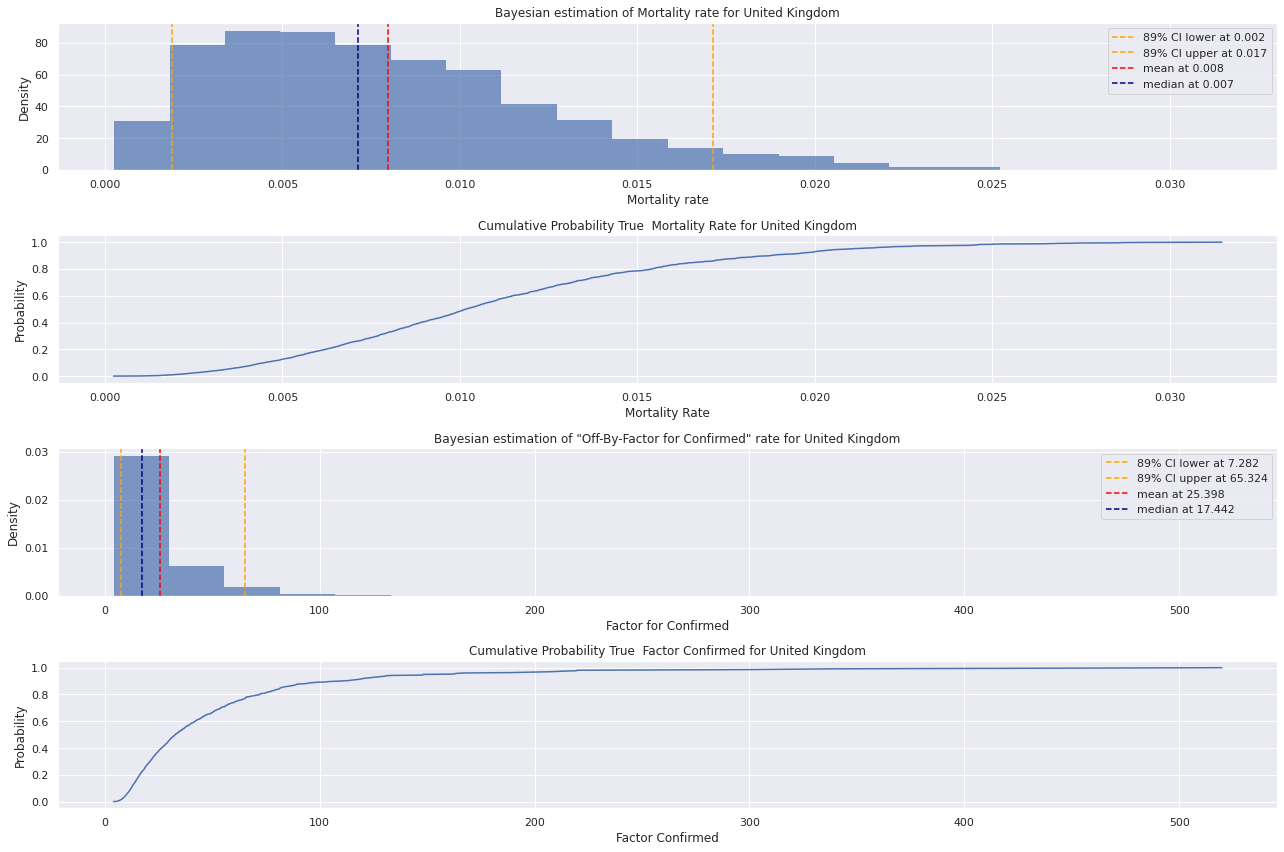

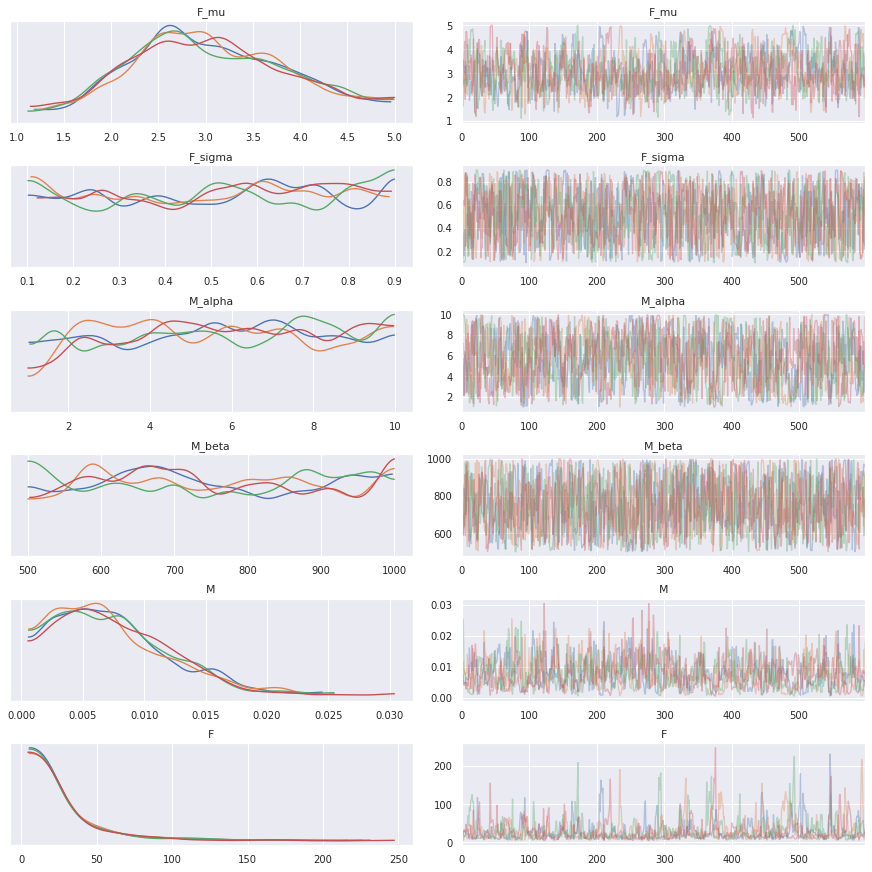

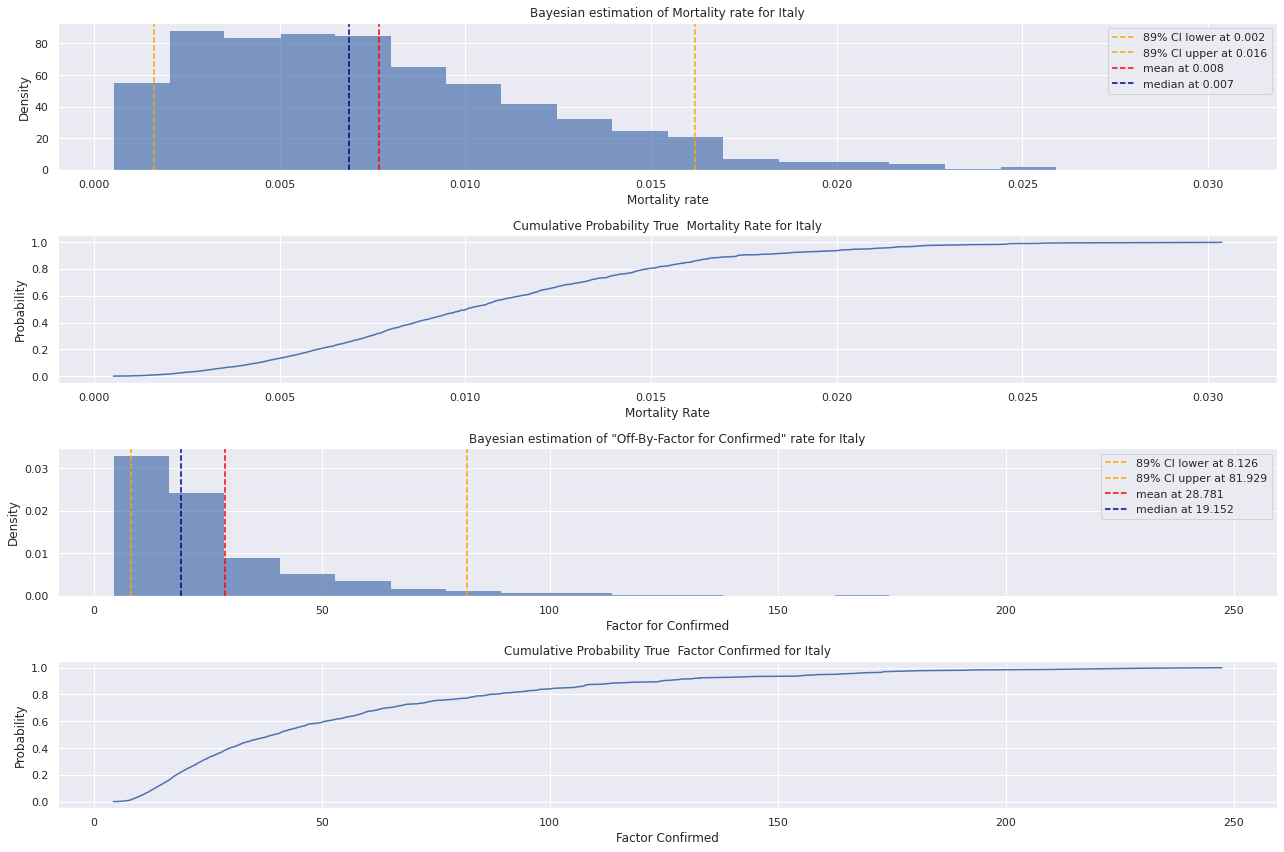

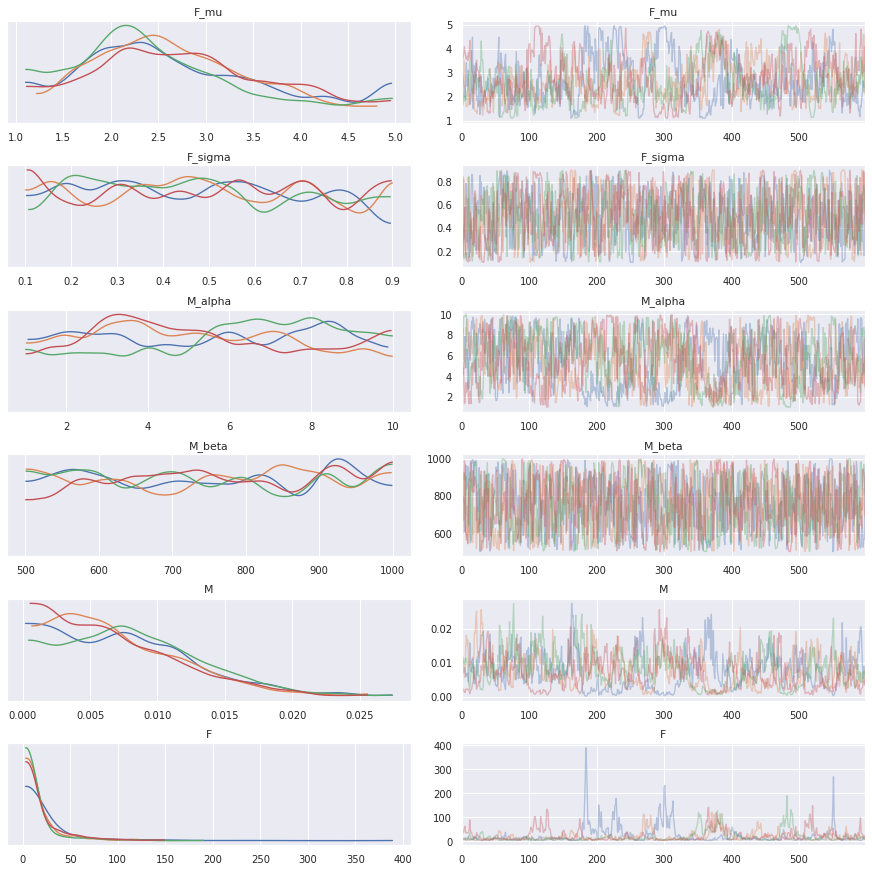

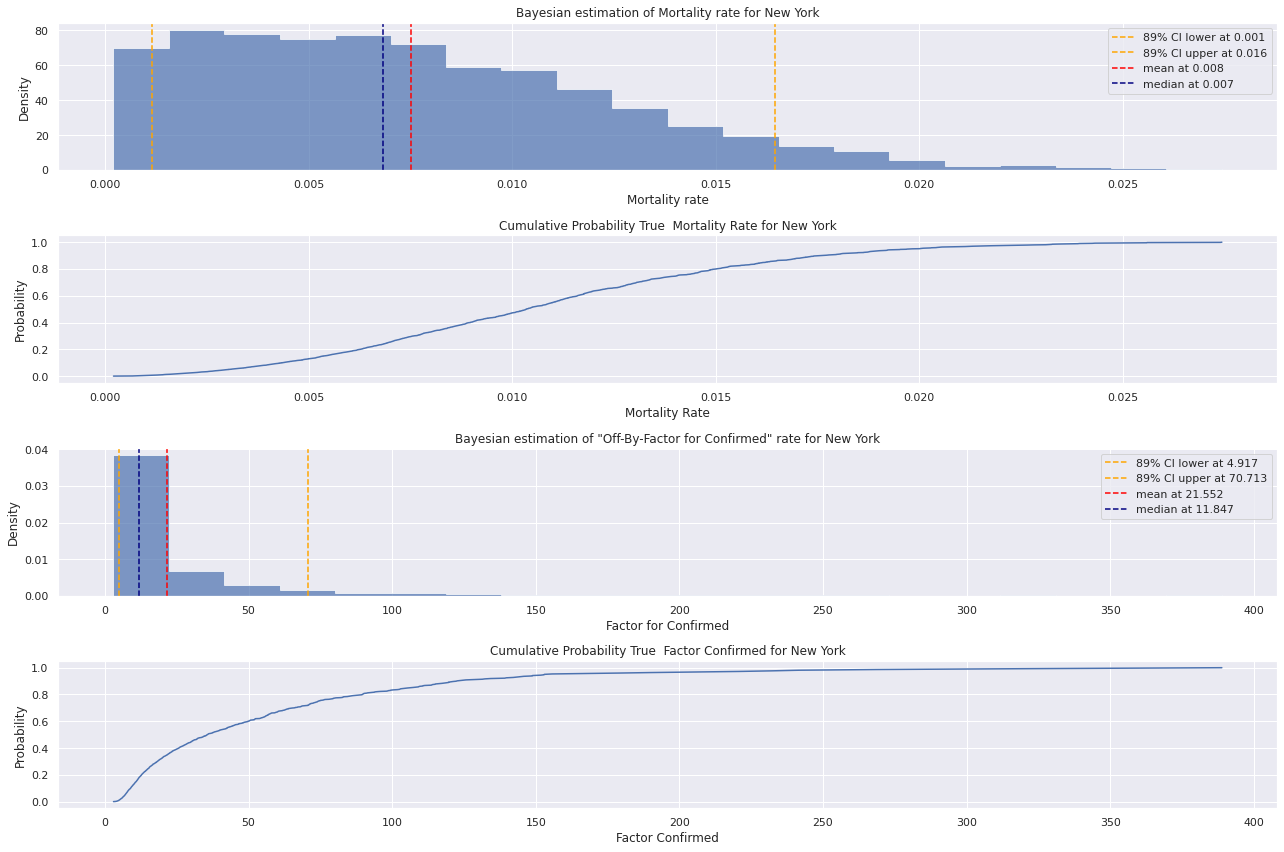

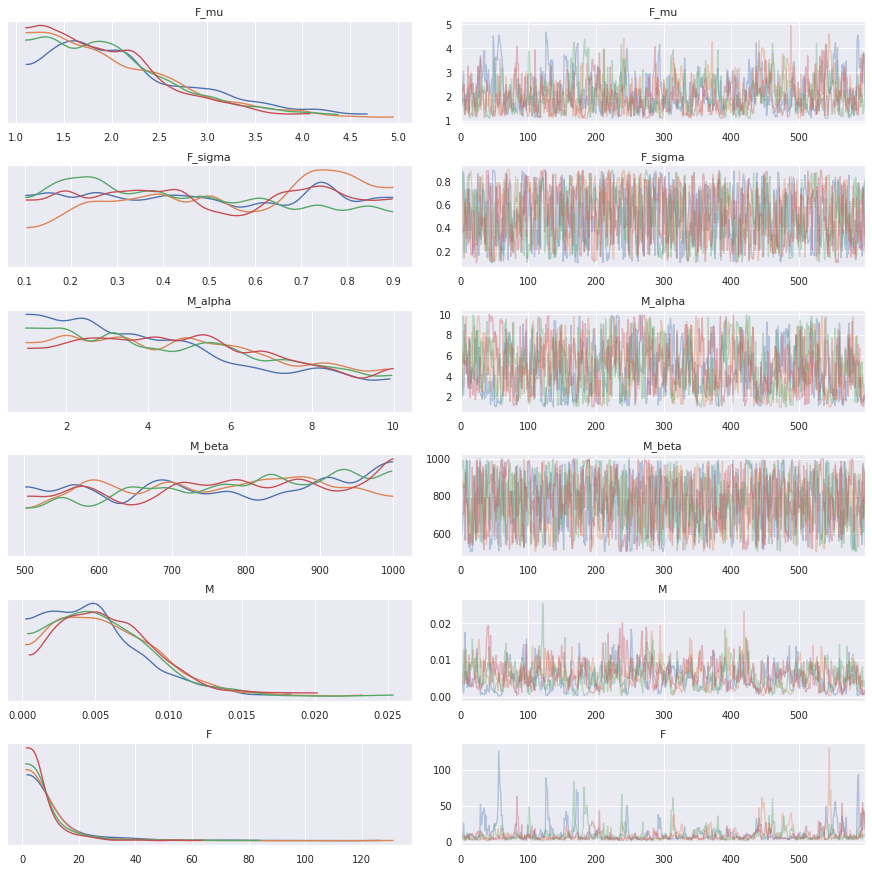

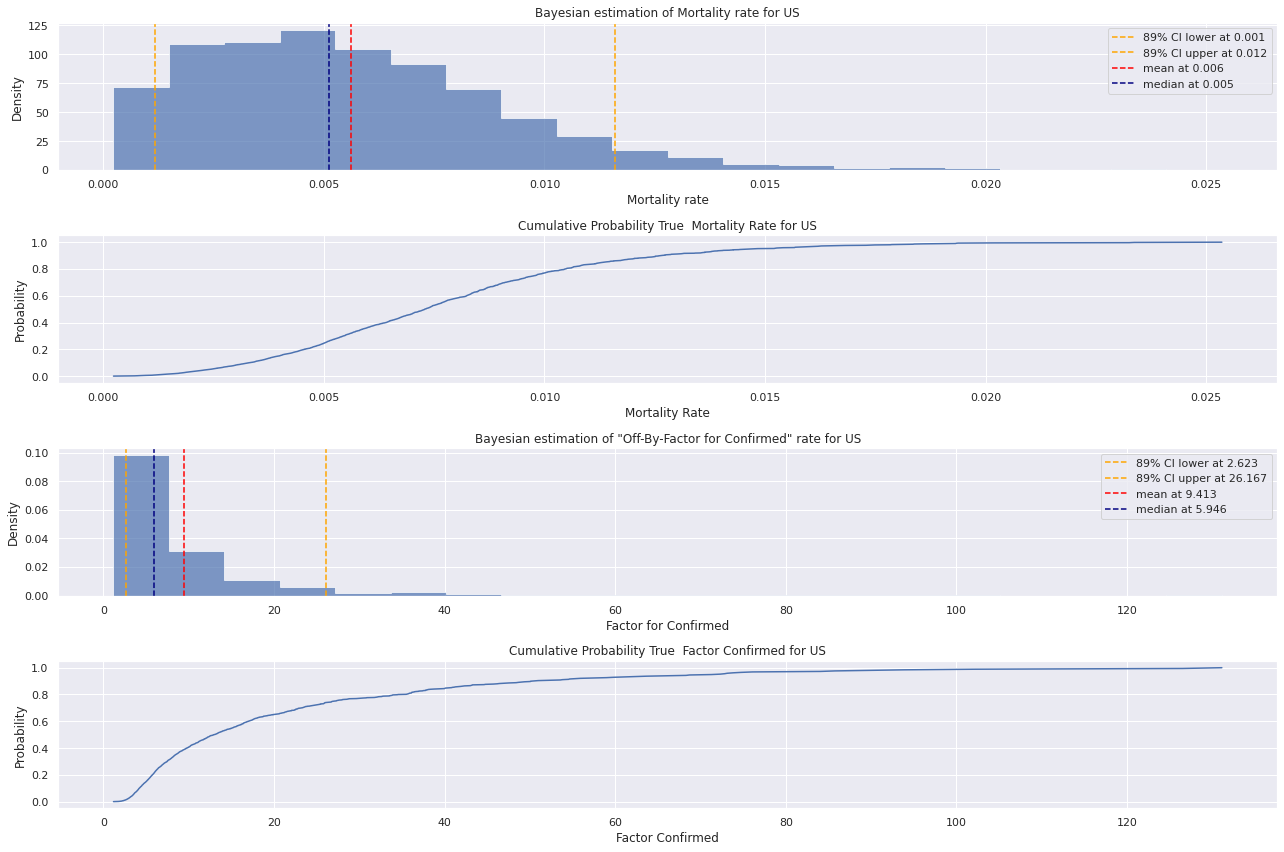

In [5]:


def process_country(country,C,D):
    df = dick[country]
    
    mask = df['confirmed'] > 500
    df = df[mask]
    mask = df['deceased'] > 5
    df = df[mask]
    #mask = df['dead_inc'] >= 0 # or it crashes when doing inc  & dead_inc
    #df = df[mask]
    mask = df['inc'] >= 0
    df = df[mask]
    
    #df = df.iloc[-10:] # Only the last n days
    
    # replace neg incs with zeros
    df['dead_inc'] = df['dead_inc'].apply(lambda x : x if x >= 0 else 0)
    
    print ('++++++++ {} ++++++++++'.format(country))
    print ()
    print (df.tail(40))
    print()
    
    if df.size < 1 :
        print ('Not enough data - DataFrame empty! ')
    else:
        confirmed_mean = df['confirmed'].mean()
        confirmed_std = df['confirmed'].std()
        dead_mean = df['deceased'].mean()
        dead_std = df['deceased'].std()

        #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
        #dead_s = (df['deceased'] - dead_mean) / dead_std

        confirmed_s = df[C]
        dead_s = df[D]

        #plt.plot(confirmed_s,dead_s,'x--')

        #M_mu = pm.Uniform('M_mu',lower=0.1,upper=1)
        
        model = pm.Model()
        
        with model:

            F_mu = pm.Uniform('F_mu',lower=1.1,upper=5)
            F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.9)

            M_alpha = pm.Uniform('M_alpha',lower=1,upper=10)
            M_beta = pm.Uniform ('M_beta',lower=500,upper=1000)


            M = pm.Beta('M',alpha=M_alpha,beta=M_beta)
            F = pm.Lognormal('F',mu=F_mu, sd=F_sigma) 

            gen_dead = confirmed_s.values * M  * F

            obs = pm.Poisson('obs',mu=gen_dead,observed=dead_s)
            
            step1 = pm.Metropolis()

            trace = pm.sample(599,tune=500,chains=4,cores=4,target_accept=0.95)

            M_alpha_post = trace['M_alpha'][:]
            M_beta_post = trace['M_beta'][:]
            F_mu_post = trace['F_mu'][:]
            F_sigma_post = trace['F_sigma'][:]
            M_post = trace['M'][:]
            F_post = trace['F'][:]


            result = pd.DataFrame({'M_alpha_post' : M_alpha_post,
                                       'M_beta_post' : M_beta_post,
                                       'F_mu_post' : F_mu_post,
                                       'F_sigma_post' : F_sigma_post,
                                       'M_post' : M_post,
                                       'F_post' : F_post})
                           
                           
        _= az.plot_trace(trace)
        print (az.summary(trace,round_to=2))


        return result
        return None

def plot(country_name,result):
    
    # For a distribution that is not severely multimodal, 
    # the HDI is the narrowest interval containing the specified mass, 
    # and the hdi function actually returns the narrowest interval.
    # HPDI does not always work properly for multimodal densities, where the HDI may be discontinuous
    
    M_low,M_high = np.percentile(result.M_post,[5.5,94.5])
    F_low,F_high = np.percentile(result.F_post,[5.5,94.5])
    
    
    plt.figure(figsize=(18,12))
    plt.subplot(411)
    plt.title('Bayesian estimation of Mortality rate for {}'.format(country_name))
    
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(M_low))
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(M_high))
    plt.axvline(result.M_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.M_post.mean()))
    plt.axvline(result.M_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.M_post.median()))

    
    hist = plt.hist(result.M_post,density=True,bins=20,alpha=0.7,color='b',histtype='stepfilled')
    #plt.fill_between(x=hpdi_M,y1=0,y2=max(hist[0]),color='r',alpha=0.7,label='HPDI-50%')
    plt.legend(loc='upper right')


    plt.subplot(413)
    plt.title('Bayesian estimation of "Off-By-Factor for Confirmed" rate for {}'.format(country_name))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(F_low))
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(F_high))
    plt.axvline(result.F_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.F_post.mean()))
    plt.axvline(result.F_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.F_post.median()))

    
    hist = plt.hist(result.F_post,density=True,bins=20,alpha=0.7,color='b',histtype='stepfilled')
    #plt.fill_between(x=hpdi_F,y1=0,y2=max(hist[0]),color='r',alpha=0.7,label='HPDI-50%')

    plt.legend(loc='upper right')
    
    plt.subplot(412)
    
    plt.title('Cumulative Probability True  Mortality Rate for {}'.format(c))
    M_samples = result.M_post 
    
    M_samples = np.sort(M_samples)
    
    M_dist = M_samples / M_samples.sum()
    plt.plot(M_samples,M_dist.cumsum())
    

    plt.ylabel('Probability')
    plt.xlabel('Mortality Rate')
    
    plt.subplot(414)
    
    plt.title('Cumulative Probability True  Factor Confirmed for {}'.format(c))
    F_samples = result.F_post 
    
    F_samples = np.sort(F_samples)
    
    F_dist = F_samples / F_samples.sum()
    plt.plot(F_samples,F_dist.cumsum())
    
    plt.ylabel('Probability')
    plt.xlabel('Factor Confirmed')
    
    plt.tight_layout()

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}_.jpg'.format(country_name),format='jpg')

countries = ['Sweden','India','Germany','United Kingdom','Italy','New York','US']
#countries = ['Spain','Italy','New York']
#countries = ['Sweden']

for c in countries:
    
    result = process_country(c,'inc','dead_inc')
    if not (result is None) :
        
        

        plot(c,result)
        print ()
        print (result.describe())
       

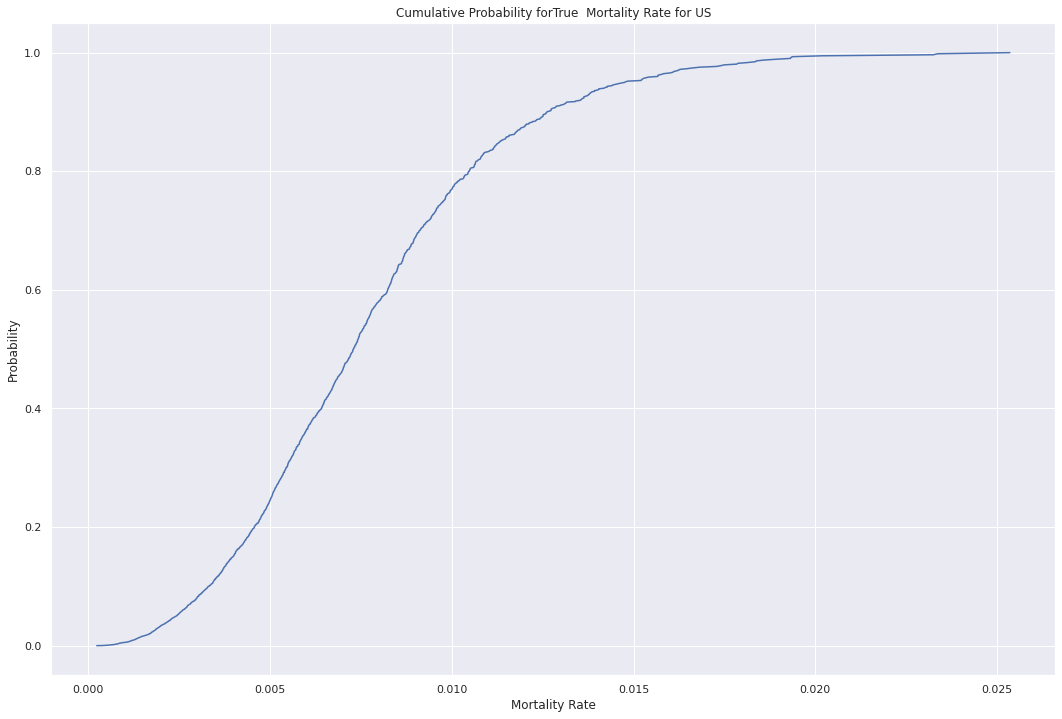

In [6]:
plt.figure(figsize=(18,12))
plt.title('Cumulative Probability forTrue  Mortality Rate for {}'.format(c))
M_samples = result.M_post 
M_samples = np.sort(M_samples)
M_dist = M_samples / M_samples.sum()
plt.plot(M_samples,M_dist.cumsum())
plt.ylabel('Probability')
plt.xlabel('Mortality Rate')
plt.savefig('Cumulative_Mortality_Rate_{}.jpg',format='jpg')

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

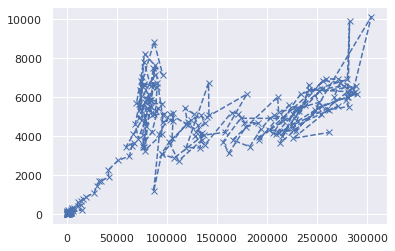

In [7]:
def process_world(df,C,D):
    
    mask = df['confirmed'] > 1000
    df = df[mask]
    mask = df['dead'] > 5
    df = df[mask]
    
    #df = df.iloc[-30:] limit number of thays
    
    confirmed_mean = df['confirmed'].mean()
    confirmed_std = df['confirmed'].std()
    dead_mean = df['dead'].mean()
    dead_std = df['dead'].std()
    
    #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
    #dead_s = (df['deceased'] - dead_mean) / dead_std
    
    confirmed_s = df[C]
    dead_s = df[D]
    
    plt.plot(confirmed_s,dead_s,'x--')
    
    #F_mu = pm.Uniform('F_mu',lower=1,upper=1.2)
    #F_sigma = pm.Uniform('F_sigma',lower=0.19,upper=0.21)
    
    #F_mu = pm.Uniform('F_mu',lower=1.1,upper=2)
    #F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.3)
    
    F_mu = pm.Uniform('F_mu',lower=1.1,upper=3)
    F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.9)
    
    #M_alpha = pm.Uniform('M_alpha',lower=1,upper=1000)
    #M_beta = pm.Uniform ('M_beta',lower=1,upper=1000)
    
    M_alpha = pm.Uniform('M_alpha',lower=1,upper=10)
    M_beta = pm.Uniform ('M_beta',lower=500,upper=1000)
    
    M = pm.Beta('M',alpha=M_alpha,beta=M_beta)
    F = pm.Lognormal('F',mu=F_mu, tau=1 / F_sigma ** 2) #0.6 0.2
    
    
    @pm.deterministic()
    def gen_dead(confirmed_s=confirmed_s,F=F,M=M):
        return confirmed_s * F * M
    
    obs = pm.Poisson('obs',mu=gen_dead,observed=True,value=dead_s)
    
    model = pm.Model([M_alpha,M_beta,F_mu,F_sigma,M,F,gen_dead,obs])
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(5000000,2000000,5)
    
    M_alpha_post = mcmc.trace('M_alpha')[:]
    M_beta_post = mcmc.trace('M_beta')[:]
    F_mu_post = mcmc.trace('F_mu')[:]
    F_sigma_post = mcmc.trace('F_sigma')[:]
    M_post = mcmc.trace('M')[:]
    F_post = mcmc.trace('F')[:]
    gen_dead_post = mcmc.trace('gen_dead')[:,0]
    
    #pmplot (M_alpha_post,'M_alpha_post')
    #pmplot(M_beta_post,'M_beta_post')
    #pmplot(F_mu_post,'F_mu_post')
    #pmplot(F_sigma_post,'F_sigma_post')
    pmplot(M_post,'M_post')
    pmplot(F_post,'F_post')
    
    result = pd.DataFrame({'M_alpha_post' : M_alpha_post,
                          'M_beta_post' : M_beta_post,
                          'F_mu_post' : F_mu_post,
                          'F_sigma_post' : F_sigma_post,
                          'M_post' : M_post,
                          'F_post' : F_post,
                          'gen_dead_post' : gen_dead_post})
    
    return result

def plot_world(result,title,official_mortality):
    
    M_low,M_high = np.percentile(result.M_post,[5.5,94.5])
    F_low,F_high = np.percentile(result.F_post,[5.5,94.5])
    
    hpdi_M = pm.utils.hpd(result.M_post, alpha=0.50)
    hpdi_F = pm.utils.hpd(result.F_post,alpha=0.50)
    
    
    plt.figure(figsize=(18,12))
    plt.subplot(411)
    plt.title('Bayesian estimation of Mortality rate for {}, official mortality {:.2f}'.format(title,official_mortality))
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(M_low))
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(M_high))
    plt.axvline(result.M_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.M_post.mean()))
    plt.axvline(result.M_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.M_post.median()))

    
    plt.axvline(hpdi_M[0],color='k',label='HPDI-50% low at {:.3f}'.format(hpdi_M[0]),ls='dashed')
    plt.axvline(hpdi_M[1],color='k',ls='dashed',label='HPDI-50% high at {:.3f}'.format(hpdi_M[1]))
    
    hist = plt.hist(result.M_post,density=True,bins=10,alpha=0.7,color='b')

    plt.legend(loc='upper right')
    plt.hist(result.M_post,density=True,bins=10)

    plt.subplot(413)
    plt.title('Bayesian estimation of "Off-By-Factor for Confirmed" rate for {}'.format(title))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower at {:.3f}'.format(F_low))
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper at {:.3f}'.format(F_high))
    plt.axvline(result.F_post.mean(),color='red',ls='dashed',label='mean at {:.3f}'.format(result.F_post.mean()))
    plt.axvline(result.F_post.median(),color='navy',ls='dashed',label='median at {:.3f}'.format(result.F_post.median()))

    
    plt.axvline(hpdi_F[0],color='k',label='HPDI-50% low at {:.3f}'.format(hpdi_F[0]),ls='dashed')
    plt.axvline(hpdi_F[1],color='k',ls='dashed',label='HPDI-50% high at {:.3f}'.format(hpdi_F[1]))
    
    hist = plt.hist(result.F_post,density=True,bins=10,alpha=0.7,color='b')

    plt.legend(loc='upper right')
    
    plt.subplot(412)
    
    plt.title('Cumulative Probability True  Mortality Rate for {}'.format(c))
    M_samples = result.M_post 
    M_samples = np.sort(M_samples)
    M_dist = M_samples / M_samples.sum()
    plt.plot(M_samples,M_dist.cumsum())
    
    plt.axvline(hpdi_M[0],ls='dashed',color='lime')
    plt.axvline(hpdi_M[1],ls='dashed',color='lime')

    plt.ylabel('Probability')
    plt.xlabel('Mortality Rate')
    
    plt.subplot(414)
    
    plt.title('Cumulative Probability True  Factor Confirmed for {}'.format(c))
    F_samples = result.F_post 
    F_samples = np.sort(F_samples)
    F_dist = F_samples / F_samples.sum()
    plt.plot(F_samples,F_dist.cumsum())
    
    plt.axvline(hpdi_F[0],ls='dashed',color='lime')
    plt.axvline(hpdi_F[1],ls='dashed',color='lime')
    
    plt.ylabel('Probability')
    plt.xlabel('Factor Confirmed')
    
    plt.tight_layout()

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}.jpg'.format(title),format='jpg')

world_df = pd.read_pickle('global_data.pkl')

result_world = process_world(world_df,'inc','dead_inc')
official_mortality = world_df.iloc[-1,6]
plot_world(result_world,'Global',official_mortality)
